In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from sklearn import datasets
from sklearn import svm

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.datasets import load_digits

from sklearn.inspection import DecisionBoundaryDisplay


import seaborn as sns

import pandas as pd

from PIL import Image
import base64
import io

import altair as alt

import fnmatch
from os.path import isfile,join
import os



In [2]:
## Load Iris  data
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

## Load MNIST data
digits = load_digits()
n_samples = len(digits.images)
digit_data = digits.images.reshape((n_samples, -1))
digit_label = digits.target


## Load MNIST (28 x 28 pixels)
mnist_784 = datasets.fetch_openml('mnist_784')

mnist_784_np = np.array(mnist_784.data)
target_np = np.array(mnist_784.target).astype("int")

mnist_784_selected = np.empty((0,784), int)

## For each digit, select first n samples
n = 500
for i in range(10):
    condition = (target_np==i)
    selected = mnist_784_np[condition, :][:n]
    mnist_784_selected = np.append(mnist_784_selected, selected, axis = 0)

## Selected mnist digit and their label
target_np_small = np.array(range(10))
target_np_small = np.repeat(target_np_small, n, axis=0)

# Singular value decomposition

"X_temp" is a design matrix;
"U" is (n * n) unitary matrix;
"sigma" is a (n * d) rectangular diagonal matrix with non-negative real numbers on the diagonal;
"W" is the projection matrix (i.e., transformation matrix) for linear transformation;

"U" and "W" are orthogonal matrices: U.T.dot(U) = I, W.T.dot(W) = I

SVD is written as: X_temp = U@(sigma)@(W.T)

Check these posts:

1)https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
2)https://www.samlau.me/test-textbook/ch/19/pca_svd.html#principal-component-analysis

In [3]:
svd = np.linalg.svd

X_temp = np.array([
    [1, 0, 5, 5],
    [0, 4, 10, 6],
    [0, 0, 2, 3]
])

U, s, WT = svd(X_temp,  full_matrices=False)

## Check SVD
print("Reconstruction of X_temp:")
print(U @ np.diag(s) @WT)

Reconstruction of X_temp:
[[ 1.00000000e+00  8.04911693e-16  5.00000000e+00  5.00000000e+00]
 [ 4.75314232e-16  4.00000000e+00  1.00000000e+01  6.00000000e+00]
 [ 8.88178420e-16 -7.77156117e-16  2.00000000e+00  3.00000000e+00]]


(150, 4)
Data Covariance Matrix: 
[[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]
Eigen vector or covariance matrix C:
(4, 4)
Principal Directions:
[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [ 0.26128628 -0.12350962 -0.80144925  0.52359713]]
Singular values:
[20.92306556 11.7091661   4.69185798  1.76273239]
Eigenvalues:
[2.93808505 0.9201649  0.14774182 0.02085386]


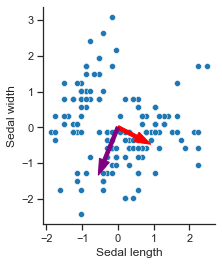

In [34]:
## Standardize the iris data
scaler = StandardScaler()

X_std = scaler.fit_transform(X)
#X_std = scaler.fit_transform(iris.data[:, :2]) # we only take the first two features of iris for this example
print(X_std.shape)

## Verify the covariance matrix C is symmetric
C = (X_std.T @ X_std)/(X_std.shape[0] - 1)
print("Data Covariance Matrix: ")
print(C)

## Eigenvector of covariance matrix C
_, v = np.linalg.eig(C)
print("Eigen vector or covariance matrix C:")
print(v.shape)

## Hence, perform singular value decomposition of X_std

## Compute the SVD of X_std
U, s, WT = svd(X_std,  full_matrices=False)
print("Principal Directions:")
print(WT)

print("Singular values:")
print(s)

print("Eigenvalues:")
eigen_val = np.power(s, 2)/(X_std.shape[0]-1) ## with (n-1) degree of freedom
print(eigen_val)

## PCA results
#0 eigenvector's eigenvalue: 2.9380850501999953
#1 eigenvector's eigenvalue: 0.9201649041624888

## Plot the principal directions (i.e.,eigenvectors)
sns.scatterplot(x=X_std[:,0], y=X_std[:,1])
sns.despine()
plt.arrow(0, 0, WT.T[:, 0][0], WT.T[:, 0][1], width=0.1, color='red')
plt.arrow(0, 0, WT.T[:, 1][0], WT.T[:, 1][1], width=0.1, color='purple')
plt.xlabel("Sedal length")
plt.ylabel("Sedal width")
plt.gca().set_aspect(1)



In [35]:
print("Check orthogonality of WT:")
print(WT.T @ WT)

print("Check the eigenvectors' L2 norm:")
for i in range(WT.shape[0]):
    print(np.linalg.norm(WT[:,i]))
    
print("Compute eigenvalues:")
for i in range(v.shape[0]):
    lamda = v[:,i].T @ C @ v[:,i]
    print(i, "eigenvector is:",v[:,i]) ## v[:,i] is equivalent to WT.T[:, i]
    print(i, "eigenvector's eigenvalue:", lamda, "/loading:", np.sqrt(lamda))


Check orthogonality of WT:
[[ 1.00000000e+00  2.35922393e-16 -4.16333634e-16 -2.49800181e-16]
 [ 2.35922393e-16  1.00000000e+00  4.85722573e-16 -1.38777878e-17]
 [-4.16333634e-16  4.85722573e-16  1.00000000e+00 -4.44089210e-16]
 [-2.49800181e-16 -1.38777878e-17 -4.44089210e-16  1.00000000e+00]]
Check the eigenvectors' L2 norm:
1.0
1.0
1.0
1.0
Compute eigenvalues:
0 eigenvector is: [ 0.52106591 -0.26934744  0.5804131   0.56485654]
0 eigenvector's eigenvalue: 2.938085050199996 /loading: 1.7140843182877545
1 eigenvector is: [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
1 eigenvector's eigenvalue: 0.9201649041624871 /loading: 0.9592522630478841
2 eigenvector is: [-0.71956635  0.24438178  0.14212637  0.63427274]
2 eigenvector's eigenvalue: 0.1477418210449479 /loading: 0.3843719826482517
3 eigenvector is: [ 0.26128628 -0.12350962 -0.80144925  0.52359713]
3 eigenvector's eigenvalue: 0.020853862176462422 /loading: 0.14440866378601536


In practice, we use a simpler method to compute the reduced dimension 𝐗 which arises from the following equivalence:
X = U @ sigma @ W.T -->
X @ W = U @ sigma @ W.T @ W --> (W.T @ W = I)
X @ W = U @ sigma

We can compute "U @ sigma" and then remove columns until we achieve our desired dimensionality.
We call the columns of "U @ sigma" the principal components of 𝐗.

In [6]:
## Compute the principal components
pcs = U @ np.diag(s)
print("Shape of Principal components of data:",pcs.shape)

Shape of Principal components of data: (150, 4)


In [7]:
## Keep the first "k" principal components
k = 1
print("Shape of first k pc:",pcs[:, 0:k].shape)

Shape of first k pc: (150, 1)


         pc_1      pc_2  label
0   -0.832494  0.173741      0
1   -0.772102 -0.258499      0
2   -0.865205 -0.134079      0
3   -0.843892 -0.229760      0
4   -0.873624  0.236212      0
..        ...       ...    ...
145  0.526645  0.138890      2
146  0.426096 -0.341847      2
147  0.411828  0.094736      2
148  0.363058  0.372690      2
149  0.227601 -0.015144      2

[150 rows x 3 columns]


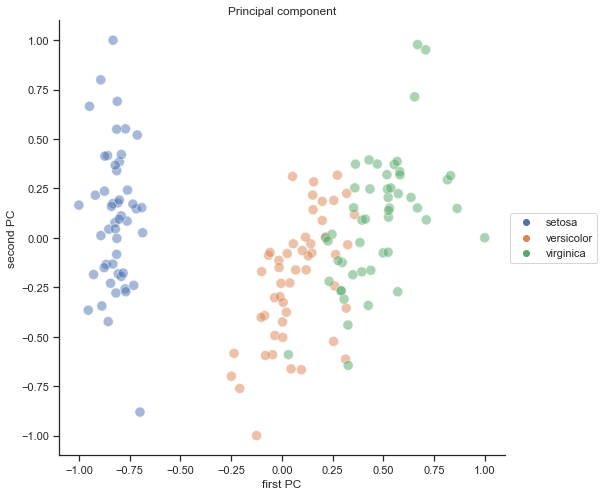

In [8]:
## Plot the first 2 principal components using SVD, and compare the result with sklearn PCA 
max_min_scaler = MinMaxScaler(feature_range=(-1, 1))

pcs = max_min_scaler.fit_transform(pcs) # Normalize PCA output to -1 and 1 range

pcs_df = pd.DataFrame({"pc_1": pcs[:,0],
                       "pc_2": -pcs[:,1], ## flip the vertical axis
                       "label": y
})

print(pcs_df)

def plot_2d(X_fitted, show_loading=False):
    """Plot PCA results"""
    plt.figure(figsize =(8, 8))

    X_fitted['class_label'] = X_fitted['label'].map({0: "setosa", 1: "versicolor", 2:"virginica"})

    hue_order = ["setosa", "versicolor", "virginica"]
    
    sns.set_context("notebook")
    sns.set_style("ticks")
    sns.scatterplot(data=X_fitted, 
                    x="pc_1", 
                    y="pc_2", 
                    hue="class_label",
                    palette="deep",
                    hue_order = hue_order,
                    legend=True,
                    s = 100,
                    alpha = 0.5)
    sns.despine()
    
    plt.title("Principal component")
    plt.xlabel("first PC")
    plt.ylabel("second PC")
    
    ## Show loadings on the principle components. This is also called Biplot
    if show_loading == True:
        pc_colors = ["black", "red", "purple", "gray"]
        comps = pca["pca"].components_
        eigen_vals = pca["pca"].explained_variance_
        explain_ratio = np.round(pca["pca"].explained_variance_ratio_, 2) * 100
        print("principle direction:", comps)
        print("eigenvector's eigenvalue:", eigen_vals)
        loadings = comps.T* np.sqrt(eigen_vals)  # scale component by its variance explanation power (i.e., Loading)
        for i, (loading, pc_color) in enumerate(zip(loadings, pc_colors)):
            print("loading:",loading)
            plt.plot(
                [0, loading[0]],
                [0, loading[1]],
                label=f"Loading of feature {i}",
                linewidth=5,
                color=pc_color,
            )
        
        plt.xlabel('first PC ({}%)'.format(explain_ratio[0]))
        plt.ylabel('second PC ({}%)'.format(explain_ratio[1]))
    
   
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_2d(pcs_df)
    


# PCA

         pc_1      pc_2  label
0   -0.832494  0.173741      0
1   -0.772102 -0.258499      0
2   -0.865205 -0.134079      0
3   -0.843892 -0.229760      0
4   -0.873624  0.236212      0
..        ...       ...    ...
145  0.526645  0.138890      2
146  0.426096 -0.341847      2
147  0.411828  0.094736      2
148  0.363058  0.372690      2
149  0.227601 -0.015144      2

[150 rows x 3 columns]
principle direction: [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
eigenvector's eigenvalue: [2.93808505 0.9201649 ]
loading: [0.89315091 0.3620387 ]
loading: [-0.46168423  0.88567345]
loading: [0.99487699 0.02349363]
loading: [0.96821173 0.06421425]


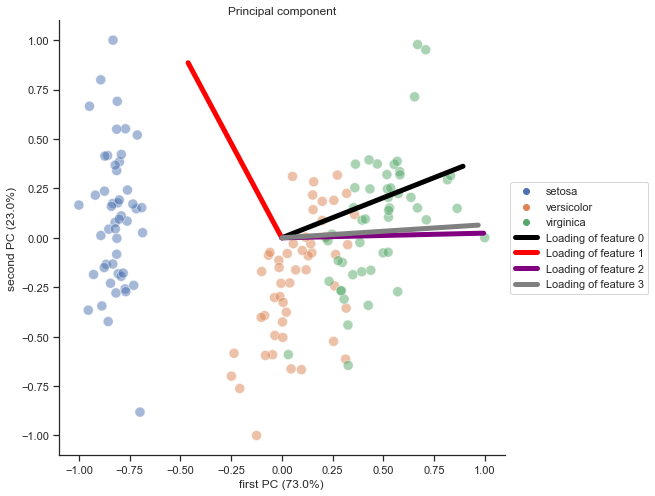

explained variance ratio (first two components): [0.72962445 0.22850762]


([<matplotlib.axis.XTick at 0x7f8ee7940430>,
 [Text(0, 0, ''), Text(0, 0, '')])

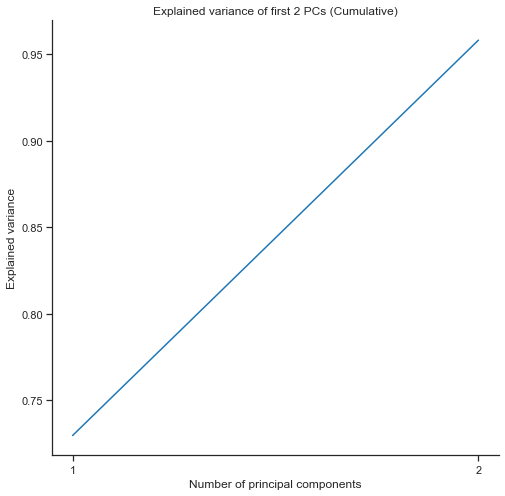

In [9]:
## Reduce to 2 dimensional
n_comp = 2

pca = make_pipeline(StandardScaler(), PCA(n_components=n_comp, random_state = 1))

## Get access to a step in Pipeline
## Note: in sklearn PCA, it flips eigenvectors' sign to enforce deterministic output
## It adjusts the columns of u and the rows of v such that the loadings in the
## columns in u that are largest in absolute value are always positive.
X_fit = pca.fit_transform(X)

X_fit = max_min_scaler.fit_transform(X_fit) # Normalize PCA output to -1 and 1 range

X_fit_df = pd.DataFrame({"pc_1": X_fit[:,0], "pc_2": X_fit[:,1], "label": y})

print(X_fit_df)


## Plot 2D dataset with principal components   
plot_2d(X_fit_df, show_loading=True)


## Percentage of variance explained for each components
explained_variances = pca["pca"].explained_variance_ratio_
print(
    "explained variance ratio (first two components): %s"
    % str(explained_variances)
)

## Plot cumulative explained variance by first 'n' principle components
explained_variances_cum = np.cumsum(pca["pca"].explained_variance_ratio_)
pc_df = pd.DataFrame(data = {'n_comp':list(range(1, n_comp+1)), 
                             'exp_var': explained_variances,
                             'exp_var_cum': explained_variances_cum})


plt.figure(figsize =(8, 8))
sns.lineplot(data=pc_df, x="n_comp", y="exp_var_cum")
sns.despine()
plt.title("Explained variance of first %s PCs (Cumulative)" % str(n_comp))
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance")
plt.xticks(np.arange(1, n_comp+1, step=1))

Note:
pca["pca"].components_: gives the same results as v[:,i] (which are eigenvectors of the data covariance matric C, "i" is the nth principal component)
pca["pca"].explained_variance_: gives the same results as v[:,i].T @ C @ v[:,i]


# Visualize principal components 
Reference: https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html

In [10]:
def plot_subplot(img_list, n_row, n_col, width, height, show_label=True):
    """Create (x_row, n_col) subplot of a list of images"""
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(width, height))
    plt.subplots_adjust(hspace = .001)

    count = -1 
    for i in range(n_row):
        for j in range(n_col):
            count = count+1
            axes[i,j].imshow(img_list[count], cmap = plt.cm.bone) ## show image
            axes[i,j].grid(False)
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            
    
    if show_label:
        rows = ['Row label {}'.format(row) for row in range(n_row)]    ## labels on the Rows
        cols = ['Column label {}'.format(col) for col in range(n_col)] ## labels on the Columns

        for ax, col in zip(axes[0], cols):
            ax.set_title(col, size='small')

        for ax, row in zip(axes[:,0], rows):
            ax.set_ylabel(row, rotation=90, size='small')

    fig.tight_layout()
    plt.show()   

In [11]:
## Reduce to 100 dimensional
n_comp = 15

pca_mnist = make_pipeline(StandardScaler(), PCA(n_components=n_comp, random_state = 1))

## Get access to a step in Pipeline

X_fit_mnist = pca_mnist.fit_transform(mnist_784_selected)

print(X_fit_mnist.shape)

(5000, 15)


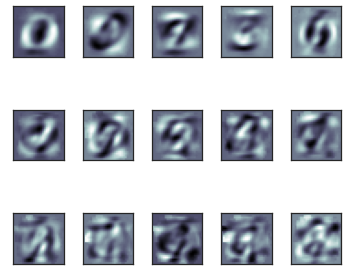

In [12]:
## Plot first 15 principal components

mnist_pc_list = pca_mnist['pca'].components_.reshape(n_comp, 28, 28)
mnist_pc_list.shape
plot_subplot(mnist_pc_list, n_row=3, n_col=5, width=5, height=5, show_label=False)


# Plot decision boundary from SVM

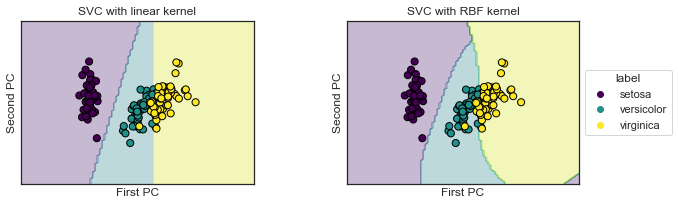

In [13]:
C = 1.0  # SVM regularization parameter

svm_models = (
    svm.SVC(kernel="linear", C=C),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
)

## Fit SVM on data after PCA
svm_models = (clf.fit(X_fit, y) for clf in svm_models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "SVC with RBF kernel",
)

# Set-up 2x2 grid for decision boundary plots
fig, sub = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_fit[:, 0], X_fit[:, 1]

for clf, title, ax in zip(svm_models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_fit,
        response_method="predict",
        cmap='viridis',
        alpha=0.3,
        ax=ax,
        xlabel="First PC",
        ylabel="Second PC",
    )
    plot = ax.scatter(X0, X1, c=y, cmap='viridis', s=50, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    #plt.legend(*plot.legend_elements(), loc='center left', title="label", bbox_to_anchor=(1, 0.5))
    plt.legend(handles=plot.legend_elements()[0],  title="label",
               loc='center left',  bbox_to_anchor=(1, 0.5), labels = ["setosa", "versicolor", "virginica"])

plt.show()


# t-SNE

In [14]:
## Initialize tSNE object
perplexity = 40
tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300, init='pca', random_state = 1)

mnist_784_selected_std =  StandardScaler().fit_transform(mnist_784_selected) 
tsne_results = tsne.fit_transform(mnist_784_selected_std)

tsne_df = pd.DataFrame({"feature_1":tsne_results[:,0], "feature_2":tsne_results[:,1], "class_label":target_np_small})


/Users/chenxiliao/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 1.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 6.696899


/Users/chenxiliao/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.931030
[t-SNE] KL divergence after 300 iterations: 2.063982


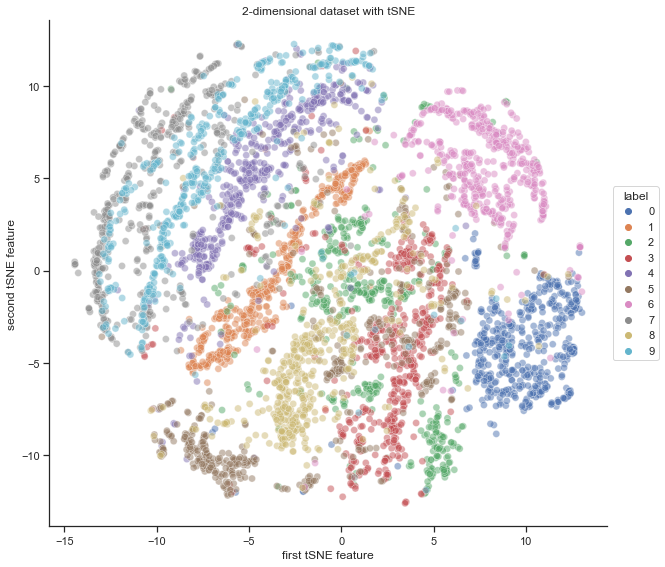

In [15]:
def plot_tSNE(X_fitted):
    """Plot tSNE results"""
    
    hue_order = list(range(10))
    
    plt.figure(figsize =(10, 10))
    
    sns.set_context("notebook")
    sns.set_style("ticks")
    sns.scatterplot(data=X_fitted, 
                    x="feature_1", 
                    y="feature_2", 
                    hue="class_label",
                    palette="deep",
                    hue_order = hue_order,
                    legend=True,
                    s = 50,
                    alpha = 0.5)
    sns.despine()
    
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with tSNE",
        xlabel="first tSNE feature",
        ylabel="second tSNE feature",
    )
    
    plt.legend(loc='center left', title="label", bbox_to_anchor=(1, 0.5))
    plt.show()
     
plot_tSNE(tsne_df)

# Wrap up visualization methods in Class

In [16]:
class visualization:
    def __init__(self, 
                 features, ## numpy array
                 labels, ## labels are coded by integers
                 preprocess = True):
        self.features = features 
        self.labels = labels
        self.preprocess = preprocess
        print(self.features.shape)
        print(self.labels.shape)
        
    def preprocess_data(self):
        X = StandardScaler().fit_transform(self.features)
        return X
    
    def apply_pca(self, n_comp):
        pca = PCA(n_components=n_comp, random_state = 1)
        if self.preprocess == True:
            X_std = self.preprocess_data()
            X_pca = pca.fit_transform(X_std)
            return pca, X_pca
        else:
            return pca, pca.fit_transform(self.features)
    
    def apply_tsne(self, n_comp, perplexity, rand_state=1):
        tsne = TSNE(n_components=n_comp, verbose=1, perplexity=perplexity, n_iter=300, random_state = rand_state)
        if self.preprocess == True:
            X_std = self.preprocess_data()
            X_tsne = tsne.fit_transform(X_std)
            return X_tsne
        else:
            return tsne.fit_transform(self.features)

        
    def plot_pca(self, 
                n_comp,
                class_dict, 
                hue_order,
                normalized=True, 
                show_loading=False,
                palette = "deep"):
        """Plot PCA results"""
        pca, X_pca = self.apply_pca(n_comp)
        
        if normalized == True:
            X_pca = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_pca)
        
        X_pca = pd.DataFrame({"pc_1": X_pca[:,0], "pc_2": X_pca[:,1], "label": self.labels})
        
        plt.figure(figsize =(8, 8))

        X_pca['class_label'] = X_pca['label'].map(class_dict)


        sns.set_context("notebook")
        sns.set_style("ticks")
        sns.scatterplot(data=X_pca, 
                        x="pc_1", 
                        y="pc_2", 
                        hue="class_label",
                        palette=palette,
                        hue_order = hue_order,
                        legend=True,
                        s = 100,
                        alpha = 0.5)
        sns.despine()

        plt.title("Principal component")
        plt.xlabel("first PC")
        plt.ylabel("second PC")
        

        ## Show loadings on the principle components. This is also called Biplot
        pc_colors = ["black", "red", "purple", "gray"]
        comps = pca.components_
        eigen_vals = pca.explained_variance_
        explain_ratio = np.round(pca.explained_variance_ratio_, 2) * 100
        
        loadings = comps.T* np.sqrt(eigen_vals)  # scale component by its variance explanation power (i.e., Loading)

        if show_loading == True:
            for i, (loading, pc_color) in enumerate(zip(loadings, pc_colors)):
                print("loading:",loading)
                plt.plot(
                    [0, loading[0]],
                    [0, loading[1]],
                    label=f"Loading of feature {i}",
                    linewidth=5,
                    color=pc_color,
                )

        plt.xlabel('first PC ({}%)'.format(explain_ratio[0]))
        plt.ylabel('second PC ({}%)'.format(explain_ratio[1]))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
         ## Plot explained variance
        explained_variances = pca.explained_variance_ratio_
        explained_variances_cum = np.cumsum(pca.explained_variance_ratio_)
        pc_df = pd.DataFrame(data = {'n_comp':list(range(1, n_comp+1)), 
                                     'exp_var': explained_variances,
                                     'exp_var_cum': explained_variances_cum})

        plt.figure(figsize =(8, 8))
        sns.barplot(data=pc_df, x="n_comp", y="exp_var", color = 'steelblue', alpha=0.8)
        sns.despine()
        plt.title("First {n_comp} PCs explain {cum_var}% variance in cumulative".format(n_comp=n_comp, cum_var=np.round(explained_variances_cum[-1], 2)*100))
        plt.xlabel("Number of principal components")
        plt.ylabel("Explained variance")
        #plt.xticks(np.arange(1, n_comp+1, step=1))
        plt.show()

        
    def plot_tsne(self, n_comp, perplexity, class_dict, hue_order, palette="deep"):
        """Plot tSNE results"""
        X_tsne = self.apply_tsne(n_comp, perplexity)
                
        X_tsne = pd.DataFrame({"tsne_1":X_tsne[:,0], "tsne_2":X_tsne[:,1], "label":self.labels})
        X_tsne['class_label'] = X_tsne['label'].map(class_dict)
                
        plt.figure(figsize =(10, 10))
        
        sns.set_context("notebook")
        sns.set_style("ticks")
        sns.scatterplot(data=X_tsne, 
                        x="tsne_1", 
                        y="tsne_2", 
                        hue="class_label",
                        palette=palette,
                        hue_order = hue_order,
                        legend=True,
                        s = 50,
                        alpha = 0.5)
        sns.despine()

        plt.gca().set(
            aspect="equal",
            title="2-dimensional dataset with tSNE",
            xlabel="first tSNE feature",
            ylabel="second tSNE feature",
        )

        plt.legend(loc='center left', title="label", bbox_to_anchor=(1, 0.5))
        plt.show()
        
    
        
        
        
    


(150, 4)
(150,)
loading: [0.89315091 0.3620387 ]
loading: [-0.46168423  0.88567345]
loading: [0.99487699 0.02349363]
loading: [0.96821173 0.06421425]


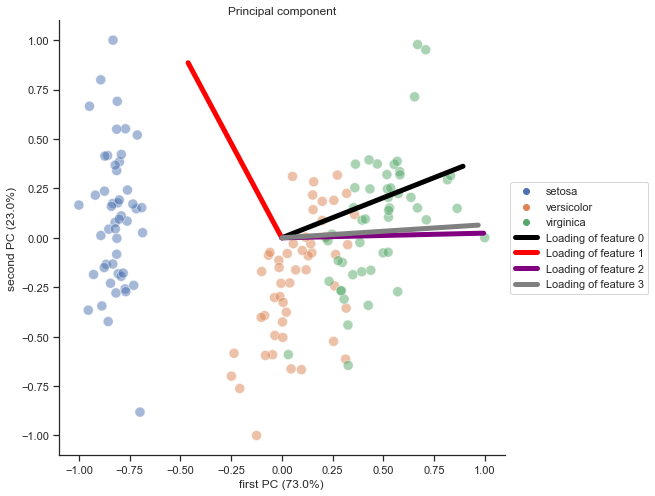

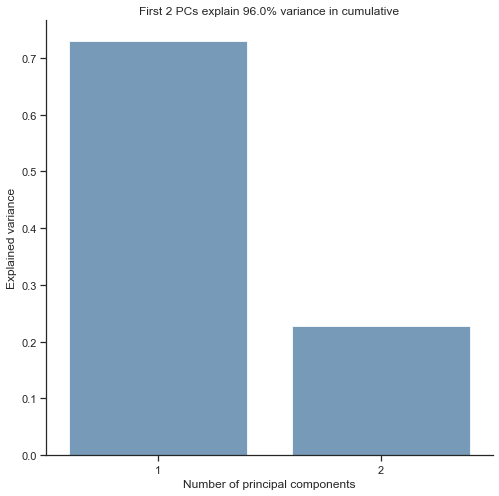

In [17]:
d1 = visualization(iris.data, iris.target)
classes = {0: "setosa", 1: "versicolor", 2:"virginica"}
hue_order = classes.values() ## alternatively, it could be hue_order=["versicolor", "virginica", "setosa"]
d1.plot_pca(n_comp=2, class_dict = classes, hue_order = hue_order, show_loading = True)

# Iteractive visualization 

In [22]:
def np_image_to_base64(im_matrix):
    """Conver numpy array to json format to display in Altair"""
    im = Image.fromarray(im_matrix)
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image
    return im_url

def get_base64_from_folder(path, resize):
    #loading and processing image from a folder. dumping them into a base64 list

    def _image_path_to_base64(path, resize):
        """Conver numpy array to json format to display in Altair"""
        im = Image.open(path)
        im = im.resize((resize, resize))
        buffer = io.BytesIO()
        im.save(buffer, format="jpeg")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        im_url = "data:image/jpeg;base64, " + encoded_image
        return im_url
    
    files = list(filter(lambda f: isfile(join(path,f)), os.listdir(path)))

    img_url_list = []
    for image in files:
        if fnmatch.fnmatch(image, '*.jpg'):
            image_path = os.path.join(path, image)
            img_url = _image_path_to_base64(image_path, resize)
            img_url_list2.append(img_url)
    return img_url_list

def scatter_plot_alt(data, x_var, y_var,image, x_lim, y_lim, class_label,legend_label, 
                 color_map,point_size, x_label, y_label):
    """Interactive scatter plot"""
    plot = alt.Chart(data).mark_circle(size=point_size).encode(
        alt.X(x_var,scale=alt.Scale(domain=x_lim), title=x_label),
        alt.Y(y_var,scale=alt.Scale(domain=y_lim), title=y_label),
        tooltip=image,
        color=alt.Color(class_label, legend=alt.Legend(title="Class"),
                        scale=alt.Scale(domain=legend_label, range=color_map))
        ).configure_axis(
            grid=False, 
            domainWidth=1.5, domainColor="black", ## edit axis stroke width and color
            tickWidth=1.5,tickColor="black", ## edit tick stroke width and color
            offset=10, tickCount=6 ## edit distance from the y-axis to x-axis
        ).configure_view(
            strokeOpacity=0 ## edit bounding box visibility
        ).properties(width=500, height=500).interactive()
    
    return plot




In [23]:
## Create corresponding image for display for the sampled digit
img_url_list = []
for image in mnist_784_selected:
    image = image.reshape(28,28).astype(np.uint8)
    img_url = np_image_to_base64(image)
    img_url_list.append(img_url)
    
tsne_df["image"] = pd.DataFrame(img_url_list)

In [24]:
target_names = list(range(10))
color_map = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
             "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

scatter_plot_alt(data = tsne_df, x_var = "feature_1", y_var = "feature_2", image=["image"],
            x_lim = (-20,20), y_lim = (-20,20), class_label = "class_label:N",
            legend_label = target_names, color_map = color_map, point_size=100,
            x_label = "t-SNE feature 1", y_label = "t-SNE feature 2")

alt.Chart(...)